# Posterior inference using numpyro

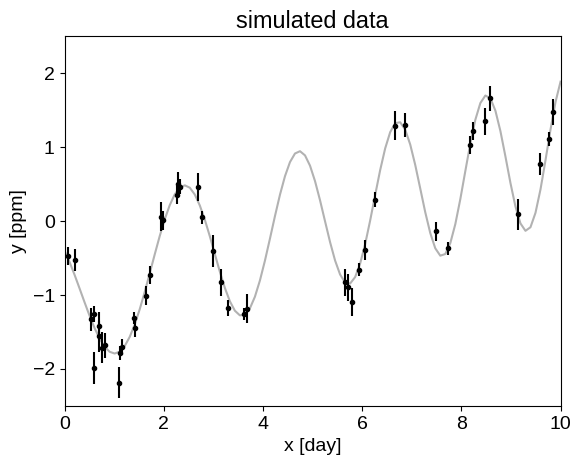

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 28),
        np.random.uniform(5.5, 10, 18),
    )
)
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from tinygp import kernels, GaussianProcess


prior_sigma = 5.0

def numpyro_model(t, yerr, y=None):
    mean = numpyro.sample("mean", dist.Normal(0.0, prior_sigma))
    jitter = numpyro.sample("jitter", dist.HalfNormal(prior_sigma))

    sigma1 = numpyro.sample("sigma1", dist.HalfNormal(prior_sigma))
    rho1 = numpyro.sample("rho1", dist.HalfNormal(prior_sigma))
    tau = numpyro.sample("tau", dist.HalfNormal(prior_sigma))
    kernel1 = sigma1 ** 2 * kernels.ExpSquared(tau) * kernels.Cosine(rho1)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(prior_sigma))
    rho2 = numpyro.sample("rho2", dist.HalfNormal(prior_sigma))
    kernel2 = sigma2 ** 2 * kernels.Matern32(rho2)

    kernel = kernel1 + kernel2
    gp = GaussianProcess(kernel, t, diag=yerr ** 2 + jitter, mean=mean)

    numpyro.sample("obs", gp.to_numpyro(), obs=y)

    if y is not None:
        gp.condition(y)
        numpyro.deterministic("pred", gp.predict(true_t))


nuts_kernel = NUTS(numpyro_model, dense_mass=True, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key = random.PRNGKey(34923)

In [3]:
%%time
mcmc.run(rng_key, t, yerr, y=y)
samples = mcmc.get_samples()
pred = samples["pred"].block_until_ready()  # Blocking to get timing right

/opt/hostedtoolcache/Python/3.9.1/x64/lib/python3.9/site-packages/numpyro/infer/mcmc.py:479: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider to use `numpyro.set_host_device_count(2)` at the beginning of your program.
  warnings.warn('There are not enough devices to run parallel chains: expected {} but got {}.'


CPU times: user 1min 24s, sys: 18.3 s, total: 1min 42s
Wall time: 1min 2s


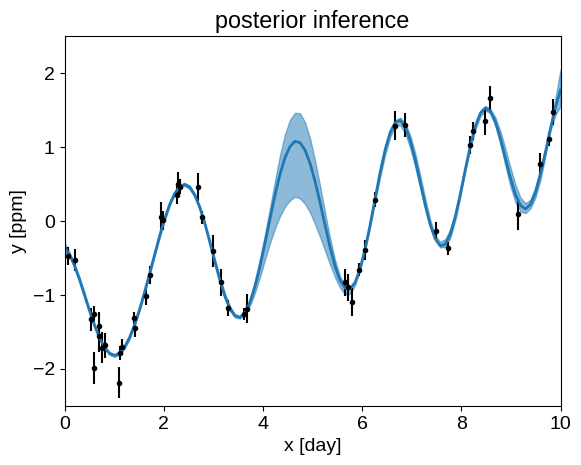

In [4]:
q = np.percentile(pred, [5, 50, 95], axis=0)
plt.fill_between(true_t, q[0], q[2], color="C0", alpha=0.5)
plt.plot(true_t, q[1], color="C0", lw=2)

plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("posterior inference")

In [5]:
import arviz as az
data = az.from_numpyro(mcmc)
az.summary(data, var_names=[v for v in data.posterior.data_vars if v != "pred"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
jitter,0.005,0.005,0.000,0.014,0.000,0.000,1767.0,1754.0,1092.0,730.0,1.00
mean,0.035,1.482,-3.044,2.556,0.060,0.047,611.0,492.0,725.0,676.0,1.00
rho1,2.247,0.776,1.774,2.675,0.054,0.042,205.0,170.0,707.0,209.0,1.01
rho2,7.685,3.146,1.806,12.830,0.094,0.066,1132.0,1132.0,1029.0,1068.0,1.00
sigma1,1.015,0.499,0.454,1.861,0.020,0.016,638.0,494.0,1169.0,756.0,1.00
sigma2,1.761,0.989,0.377,3.676,0.036,0.026,747.0,711.0,796.0,762.0,1.00
tau,2.460,1.052,0.573,4.224,0.044,0.031,573.0,572.0,512.0,275.0,1.01
